In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
df = pd.read_csv('serieWind109.csv', sep=';')
df['timewind'] = pd.to_datetime(df['timewind'])
df = df[(df.timewind >= '2015-01-01 00:00:00')]

In [3]:
df.head()

,timewind,ts50_pressure,ts50_temperature,ts50_winddirection,ts50_windspeed,ts120_pressure,ts120_temperature,ts120_winddirection,ts120_windspeed,stations_id
131496,2015-01-01 00:00:00,100499.0,299.62,307.23,4.45,100499.0,299.62,306.87,5.00,109
131497,2015-01-01 01:00:00,100590.0,299.47,303.43,3.98,100590.0,299.47,303.37,4.45,109
131498,2015-01-01 02:00:00,100649.0,299.44,296.47,3.59,100649.0,299.44,296.63,4.01,109
131499,2015-01-01 03:00:00,100672.0,299.35,288.45,3.35,100672.0,299.35,288.60,3.75,109
131500,2015-01-01 04:00:00,100665.0,299.32,275.50,2.94,100665.0,299.32,275.47,3.29,109


In [4]:
df.shape

(2161, 10)

In [5]:
FORECAST_LENGTH = 30
WINDOW = 48
FEATURE = 'ts50_windspeed'

In [6]:
validate = df[FEATURE].tail(FORECAST_LENGTH)
df.drop(df[FEATURE].tail(FORECAST_LENGTH).index,inplace=True)
uni_data = df[FEATURE]
uni_data.index = df['timewind']
uni_data.head()

timewind
2015-01-01 00:00:00    4.45
2015-01-01 01:00:00    3.98
2015-01-01 02:00:00    3.59
2015-01-01 03:00:00    3.35
2015-01-01 04:00:00    2.94
Name: ts50_windspeed, dtype: float64

In [7]:
print(uni_data.size)
print(validate.size)

2131
30


In [8]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [9]:
EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 150
TRAIN_SPLIT = int(df.shape[0] - (df.shape[0] * 0.15))

In [10]:
TRAIN_SPLIT

1811

In [11]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i,i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [12]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

## LSTM Univariate Single-Step

In [13]:
univar_hist_window = WINDOW
horizon = 1
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.39862205]
 [0.3523622 ]
 [0.31397638]
 [0.29035433]
 [0.25      ]
 [0.21259843]
 [0.1988189 ]
 [0.18011811]
 [0.14074803]
 [0.08858268]
 [0.11712598]
 [0.15452756]
 [0.16633858]
 [0.16141732]
 [0.15649606]
 [0.19488189]
 [0.21555118]
 [0.31200787]
 [0.45275591]
 [0.57775591]
 [0.66437008]
 [0.7007874 ]
 [0.70866142]
 [0.66338583]
 [0.61318898]
 [0.56200787]
 [0.49704724]
 [0.42716535]
 [0.34251969]
 [0.26279528]
 [0.21653543]
 [0.18700787]
 [0.15255906]
 [0.12106299]
 [0.17322835]
 [0.2480315 ]
 [0.28937008]
 [0.30413386]
 [0.34744094]
 [0.42322835]
 [0.44291339]
 [0.47637795]
 [0.55610236]
 [0.63779528]
 [0.68602362]
 [0.67814961]
 [0.6476378 ]
 [0.57677165]]

 Target horizon
[[0.53937008]]


In [14]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2023-04-22 10:31:23.858785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model_path = f'MODEL_LSTM_Univarient_2_{FEATURE}.h5'

In [16]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

In [17]:
lstm_model.compile(optimizer='adam', loss='mse')

In [18]:
EVALUATION_INTERVAL = 100
history = lstm_model.fit(
    train_univariate, 
    epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
    verbose =1,
    callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
)

Epoch 1/100


2023-04-22 10:31:26.233434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


100/100 [==============================] - 18s 154ms/step - loss: 0.0314 - val_loss: 0.0139
Epoch 2/100
100/100 [==============================] - 16s 165ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 3/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 5/100
100/100 [==============================] - 17s 169ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 6/100
100/100 [==============================] - 18s 183ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/100
100/100 [==============================] - 17s 167ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/100
100/100 [==============================] - 17s 170ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/100
100/100 [==============================] - 19s 193ms/step - los

In [19]:
Trained_model = tf.keras.models.load_model(model_path)

In [20]:
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


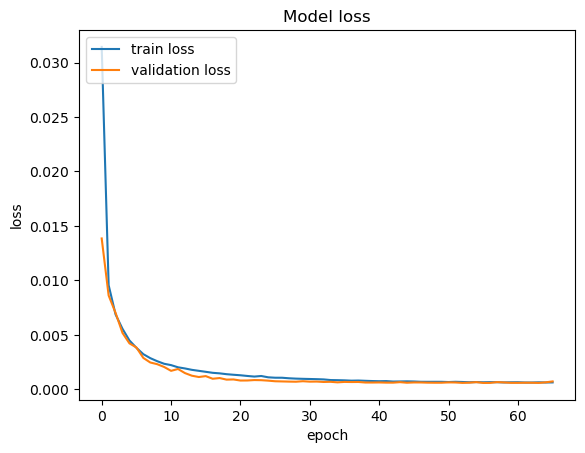

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [22]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = FORECAST_LENGTH
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
for i in range(1, window_len+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    #print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    #print(val_rescaled)

In [23]:
result_inv_trans = scaler_x.inverse_transform(result)
#result_inv_trans

In [24]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 0.4553488762124724
MAE is : 0.5236150593558946
RMSE is : 0.6747954328627843
MAPE is : 32.60151883112415
R2 is : 0.5744988476754495



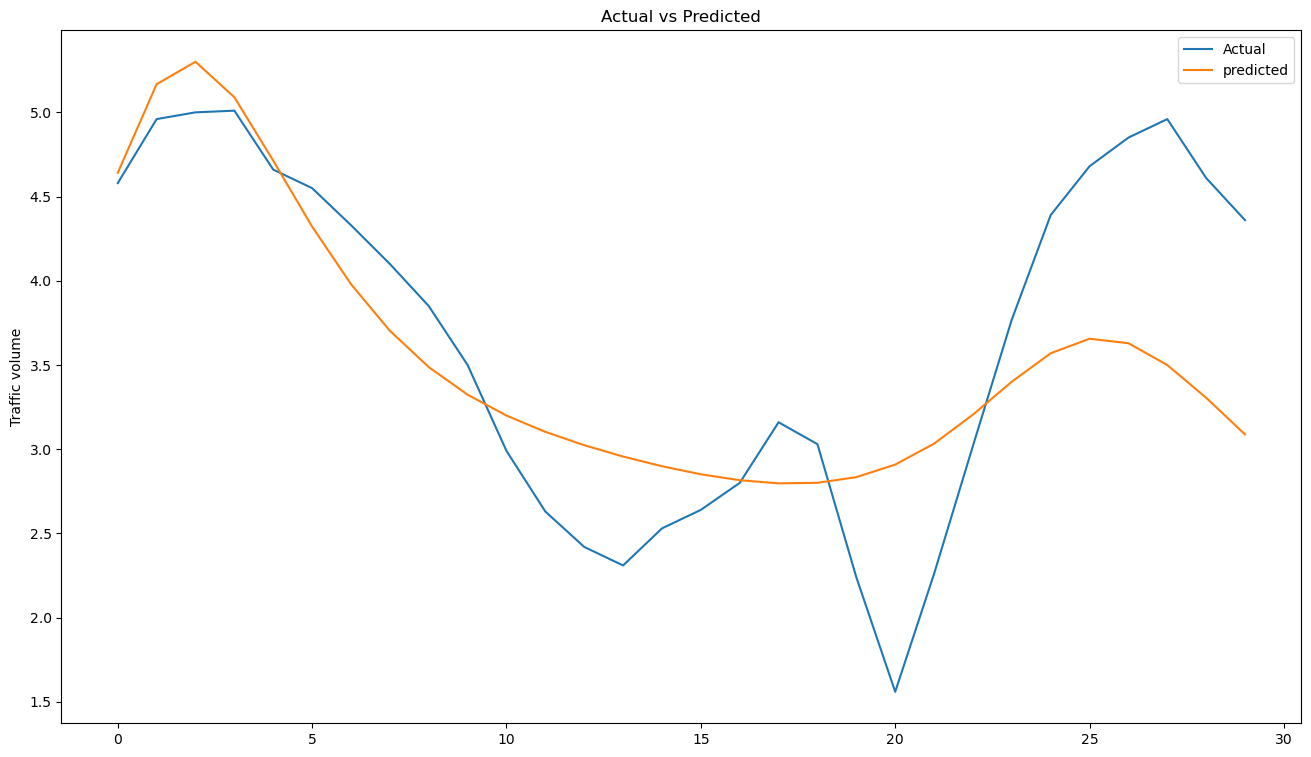

In [25]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## LSTM Univariate Horizon

In [26]:
univar_hist_window = WINDOW
horizon = FORECAST_LENGTH
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.39862205]
 [0.3523622 ]
 [0.31397638]
 [0.29035433]
 [0.25      ]
 [0.21259843]
 [0.1988189 ]
 [0.18011811]
 [0.14074803]
 [0.08858268]
 [0.11712598]
 [0.15452756]
 [0.16633858]
 [0.16141732]
 [0.15649606]
 [0.19488189]
 [0.21555118]
 [0.31200787]
 [0.45275591]
 [0.57775591]
 [0.66437008]
 [0.7007874 ]
 [0.70866142]
 [0.66338583]
 [0.61318898]
 [0.56200787]
 [0.49704724]
 [0.42716535]
 [0.34251969]
 [0.26279528]
 [0.21653543]
 [0.18700787]
 [0.15255906]
 [0.12106299]
 [0.17322835]
 [0.2480315 ]
 [0.28937008]
 [0.30413386]
 [0.34744094]
 [0.42322835]
 [0.44291339]
 [0.47637795]
 [0.55610236]
 [0.63779528]
 [0.68602362]
 [0.67814961]
 [0.6476378 ]
 [0.57677165]]

 Target horizon
[[0.53937008]
 [0.50098425]
 [0.44586614]
 [0.39862205]
 [0.36417323]
 [0.33858268]
 [0.32972441]
 [0.32677165]
 [0.31496063]
 [0.29035433]
 [0.32086614]
 [0.35137795]
 [0.35531496]
 [0.34350394]
 [0.37204724]
 [0.42913386]
 [0.43307087]
 [0.45570866]
 [0.51673228]
 [0.60137795]


In [27]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [28]:
model_path = f'MODEL_LSTM_Univarient_1_{FEATURE}.h5'

In [29]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')

In [30]:
EVALUATION_INTERVAL = 100
history = lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate,
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 23s 208ms/step - loss: 0.0571 - val_loss: 0.0246
Epoch 2/100
100/100 [==============================] - 22s 221ms/step - loss: 0.0307 - val_loss: 0.0182
Epoch 3/100
100/100 [==============================] - 24s 236ms/step - loss: 0.0208 - val_loss: 0.0173
Epoch 4/100
100/100 [==============================] - 22s 222ms/step - loss: 0.0189 - val_loss: 0.0156
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 0.0178 - val_loss: 0.0160
Epoch 6/100
100/100 [==============================] - 23s 226ms/step - loss: 0.0167 - val_loss: 0.0171
Epoch 7/100
100/100 [==============================] - 21s 213ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 8/100
100/100 [==============================] - 22s 224ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 9/100
100/100 [==============================] - 28s 282ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 10/100
100/100 [==============================] - 24s 242m

In [31]:
Trained_model = tf.keras.models.load_model(model_path)
Trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
Total params: 72,530
Trainable params: 72,530
Non-trainable params: 0
_________________________________________________________________


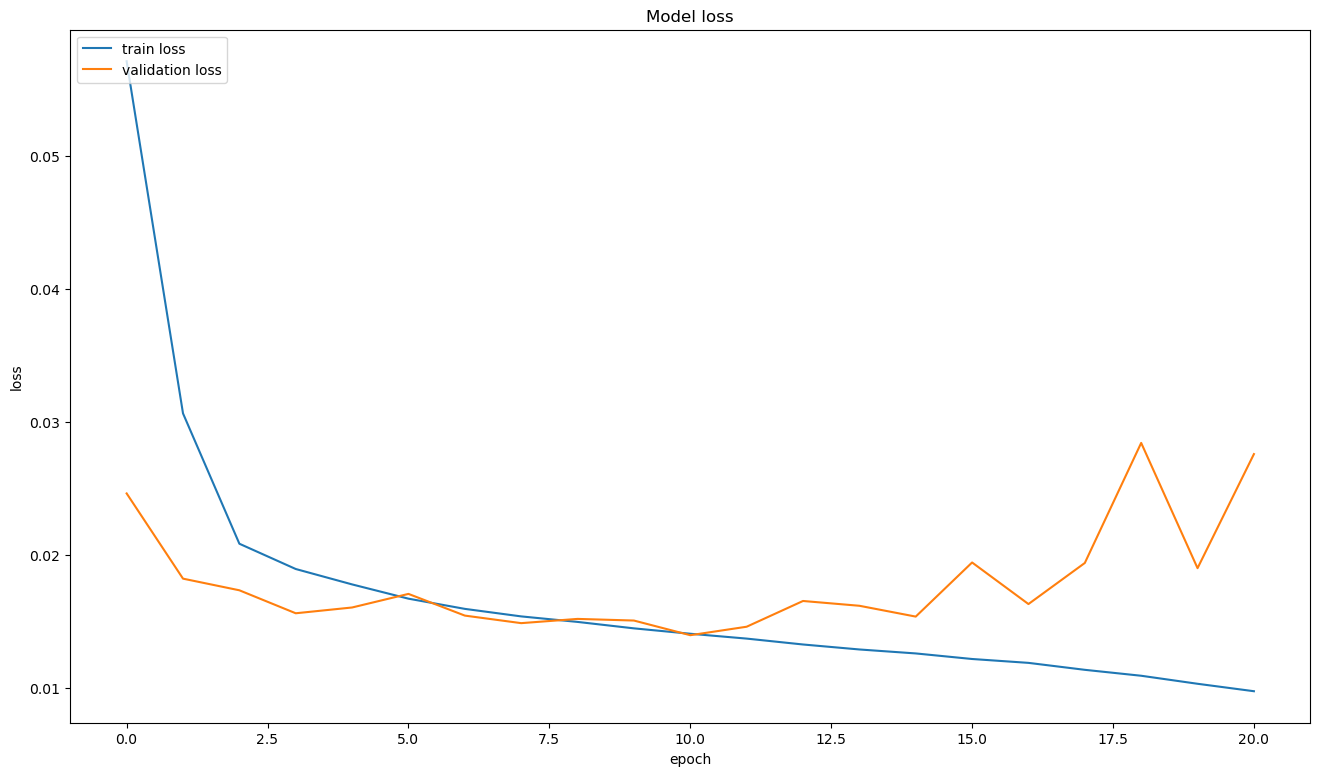

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [33]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
Predicted_results = Trained_model.predict(val_rescaled)
#Predicted_results

In [34]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)
#Predicted_inver_res

In [35]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 0.9131799395989775
MAE is : 0.8038855028152466
RMSE is : 0.9556044891057061
MAPE is : 21.065673833264725
R2 is : 0.14667821339319387



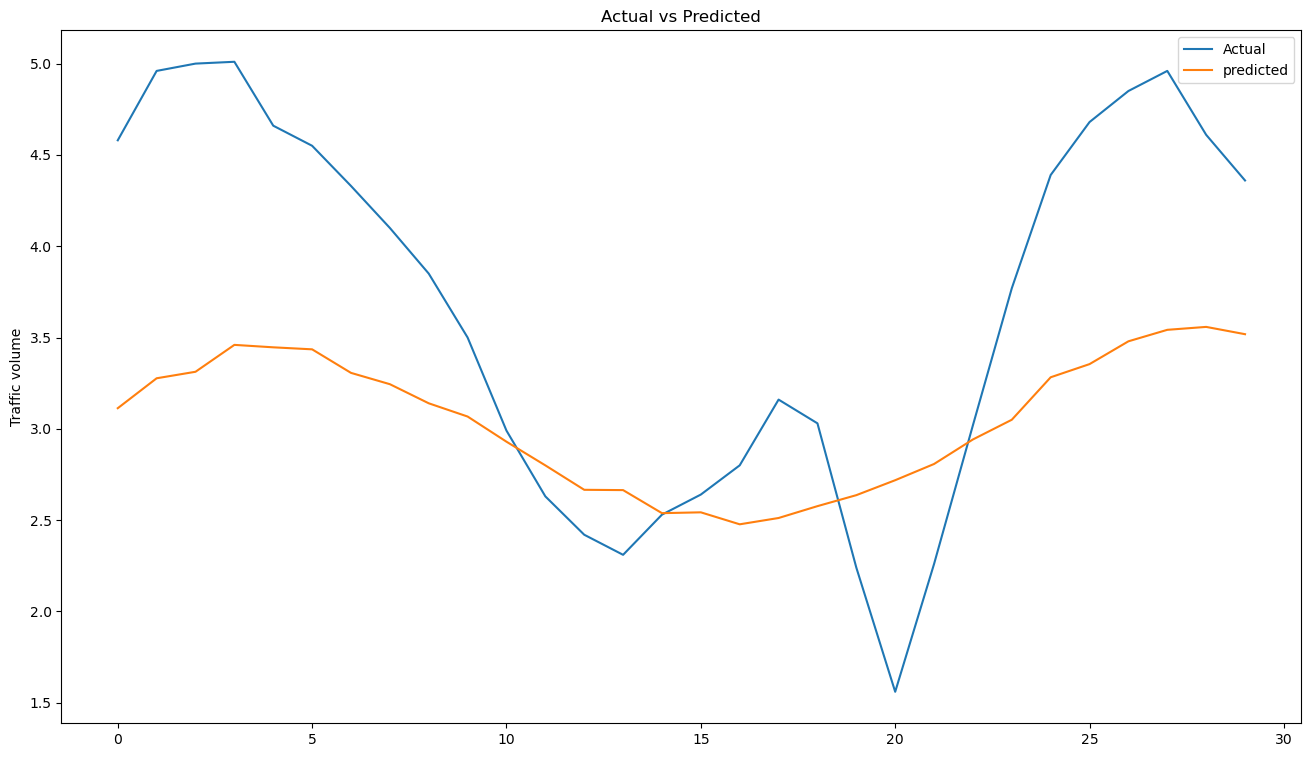

In [36]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Bidirectional LSTM Univariate Single-Step

In [37]:
univar_hist_window = WINDOW
horizon = 1
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [38]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [39]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

In [40]:
model_path = f'MODEL_Bi_directional_LSTM_Univarient_2_{FEATURE}.h5'

In [41]:
EVALUATION_INTERVAL = 100
history = Bi_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 53s 476ms/step - loss: 0.0473 - val_loss: 0.0248
Epoch 2/100
100/100 [==============================] - 44s 437ms/step - loss: 0.0231 - val_loss: 0.0091
Epoch 3/100
100/100 [==============================] - 43s 428ms/step - loss: 0.0136 - val_loss: 0.0045
Epoch 4/100
100/100 [==============================] - 42s 424ms/step - loss: 0.0088 - val_loss: 0.0038
Epoch 5/100
100/100 [==============================] - 46s 457ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 6/100
100/100 [==============================] - 43s 434ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 7/100
100/100 [==============================] - 40s 400ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 8/100
100/100 [==============================] - 41s 409ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 9/100
100/100 [==============================] - 41s 410ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 10/100
100/100 [==============================] - 39s 387m

In [42]:
Trained_model = tf.keras.models.load_model(model_path)

In [43]:
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 184,041
Trainable params: 184,041
Non-trainable params: 0
_________________________________________________________________


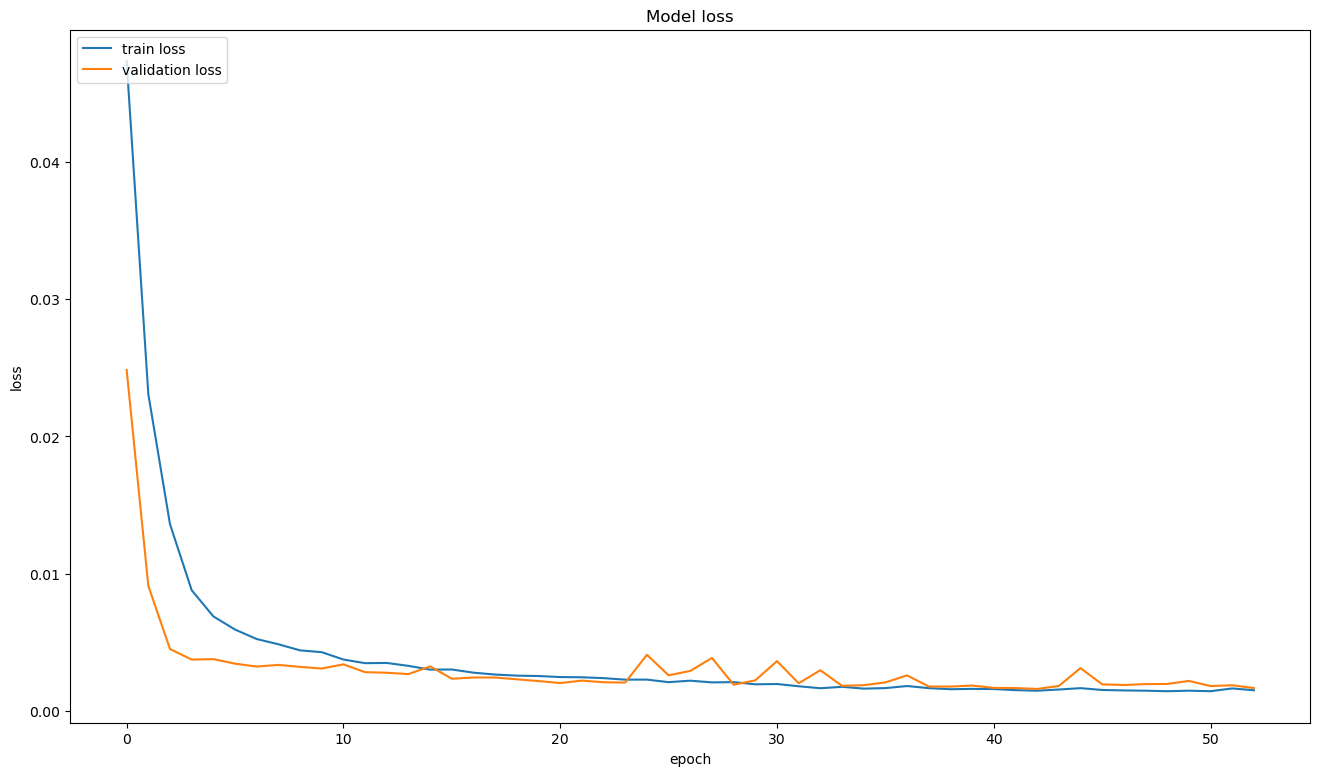

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [45]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = FORECAST_LENGTH
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
for i in range(1, window_len+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    #print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    #print(val_rescaled)

In [46]:
result_inv_trans = scaler_x.inverse_transform(result)

In [47]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 0.44633365594808155
MAE is : 0.516509805570046
RMSE is : 0.6680820727635801
MAPE is : 32.69289629600363
R2 is : 0.5829231280708798



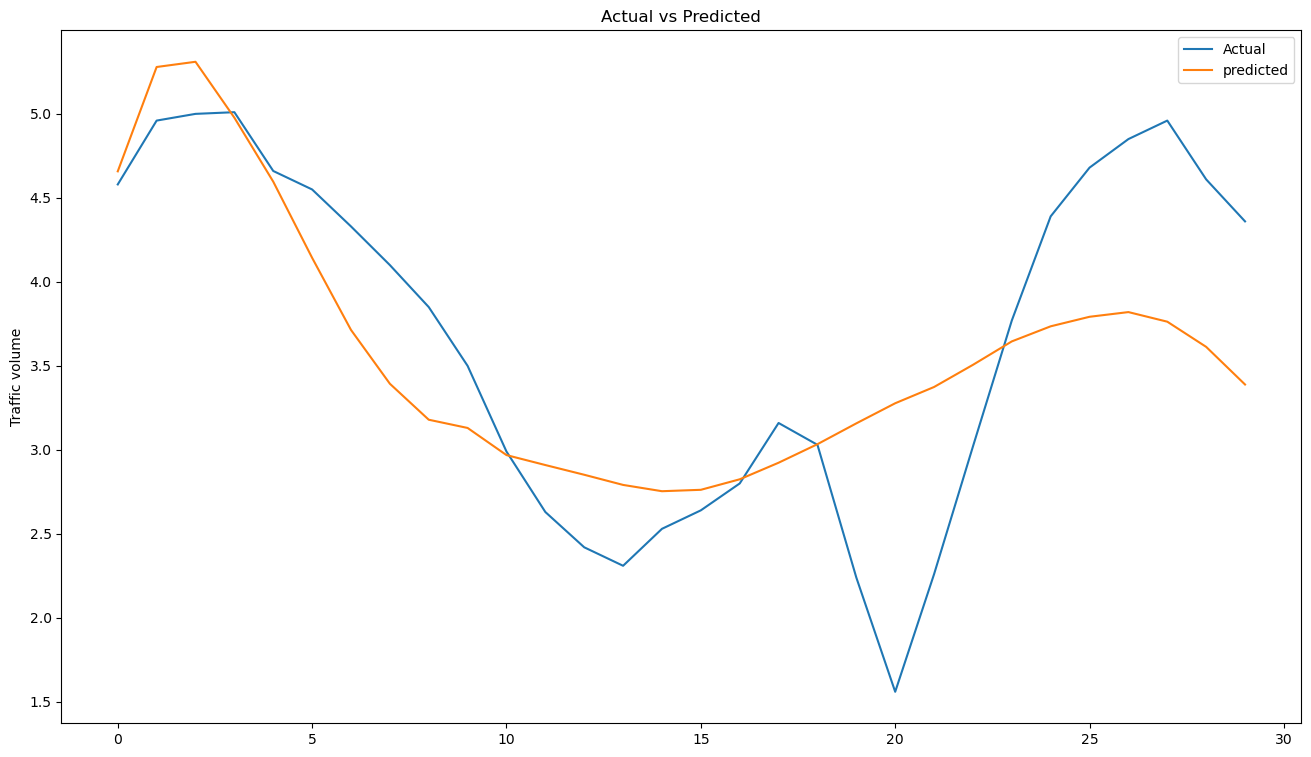

In [48]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Bidirectional LSTM Univariate Horizon

In [49]:
univar_hist_window = WINDOW
horizon = FORECAST_LENGTH
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [50]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [51]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True),
                               input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

In [52]:
model_path = f'MODEL_Bidirectional_LSTM_Univarient_1_{FEATURE}.h5'

In [53]:
EVALUATION_INTERVAL = 100
history = Bi_lstm_model.fit(
    train_univariate, 
    epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 54s 489ms/step - loss: 0.1226 - val_loss: 0.0329
Epoch 2/100
100/100 [==============================] - 46s 459ms/step - loss: 0.0536 - val_loss: 0.0245
Epoch 3/100
100/100 [==============================] - 49s 491ms/step - loss: 0.0356 - val_loss: 0.0270
Epoch 4/100
100/100 [==============================] - 47s 468ms/step - loss: 0.0312 - val_loss: 0.0276
Epoch 5/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0291 - val_loss: 0.0269
Epoch 6/100
100/100 [==============================] - 46s 462ms/step - loss: 0.0269 - val_loss: 0.0259
Epoch 7/100
100/100 [==============================] - 41s 410ms/step - loss: 0.0248 - val_loss: 0.0231
Epoch 8/100
100/100 [==============================] - 41s 414ms/step - loss: 0.0228 - val_loss: 0.0216
Epoch 9/100
100/100 [==============================] - 41s 407ms/step - loss: 0.0211 - val_loss: 0.0222
Epoch 10/100
100/100 [==============================] - 42s 416m

In [54]:
Trained_model = tf.keras.models.load_model(model_path)

In [55]:
Trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
Total params: 184,650
Trainable params: 184,650
Non-trainable params: 0
_________________________________________________________________


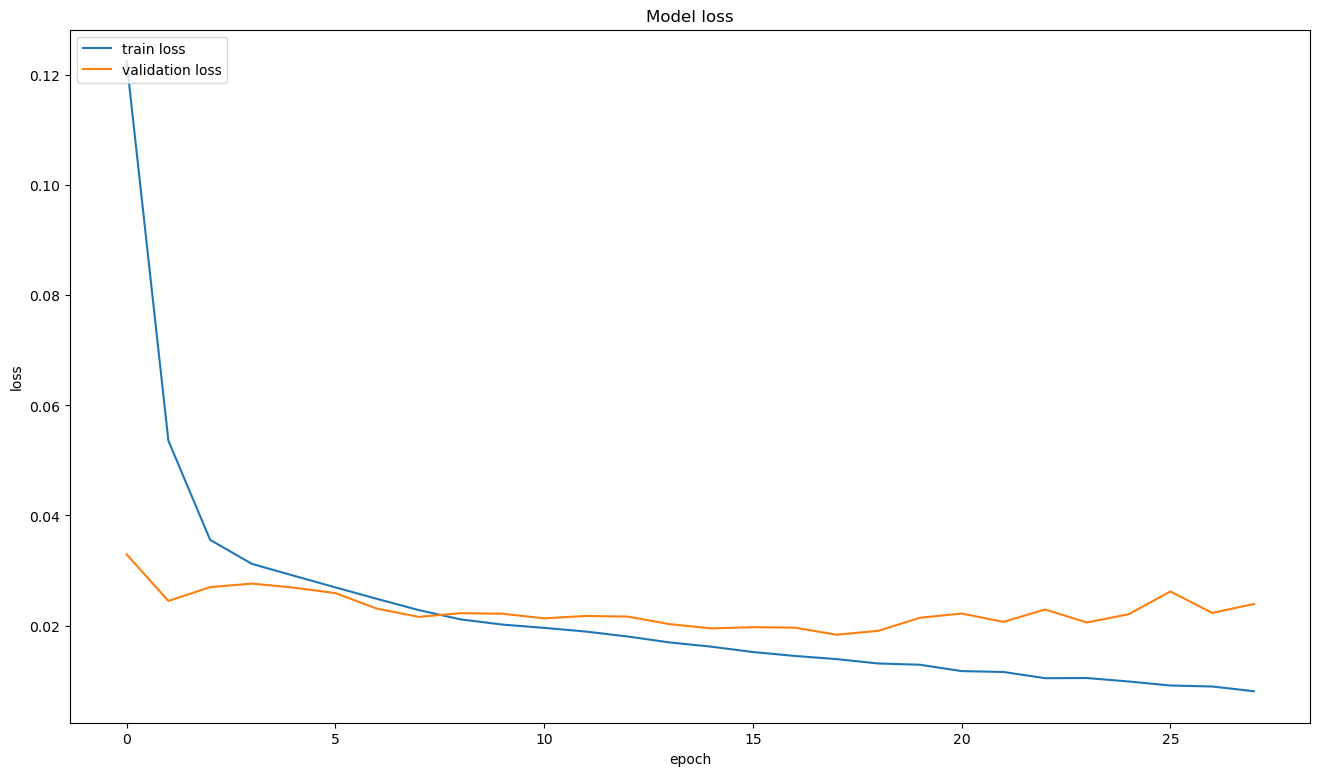

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [57]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
scaler_val = preprocessing.StandardScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
Predicted_results = Trained_model.predict(val_rescaled)
#Predicted_results

In [58]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)
#Predicted_inver_res

In [59]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 0.8789252372678295
MAE is : 0.8036201597849529
RMSE is : 0.9375101264881514
MAPE is : 21.91906390031943
R2 is : 0.17868754969742318



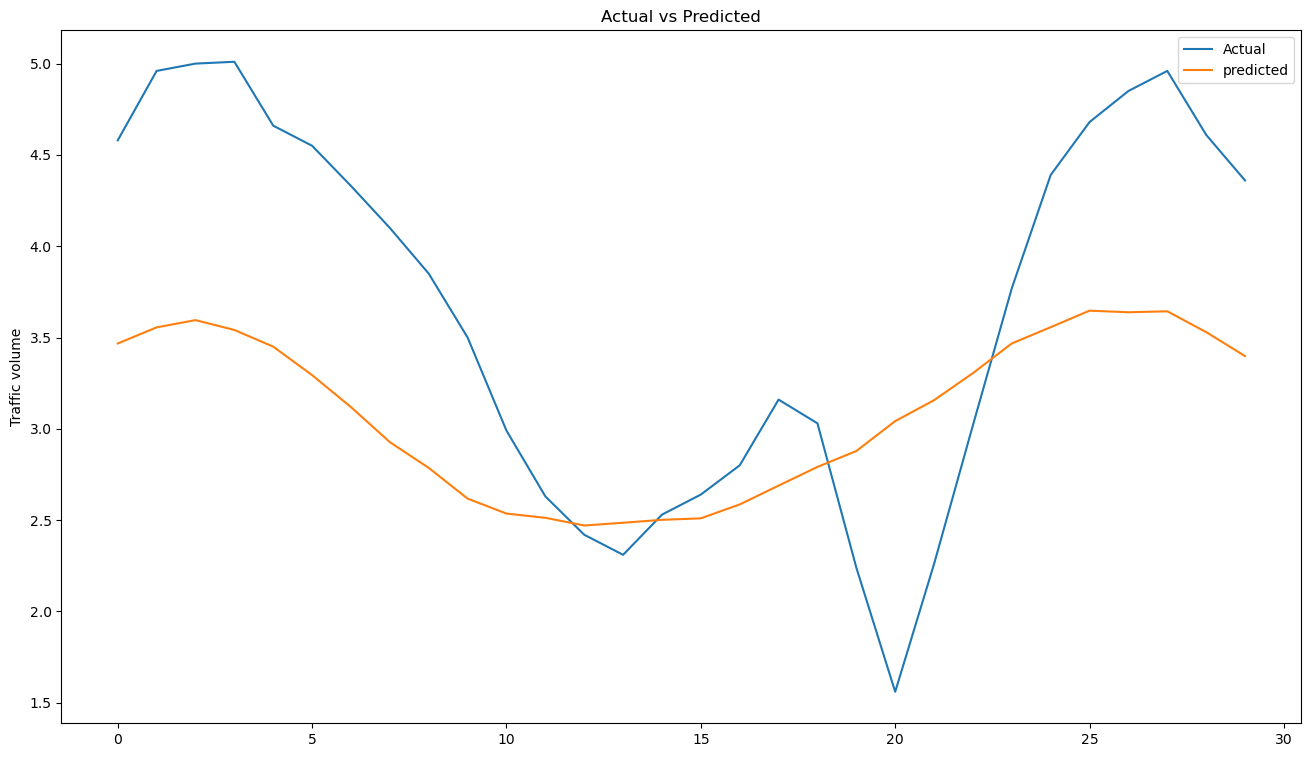

In [60]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## GRU Univariate Single-Step

In [61]:
univar_hist_window = WINDOW
horizon = 1
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [62]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [63]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
GRU_model.compile(optimizer='adam', loss='mse')

In [64]:
model_path = f'MODEL_GRU_Univarient_2_{FEATURE}.h5'

In [65]:
EVALUATION_INTERVAL = 100
history = GRU_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
    verbose =1, 
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 16s 138ms/step - loss: 0.0173 - val_loss: 0.0055
Epoch 2/100
100/100 [==============================] - 14s 140ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 3/100
100/100 [==============================] - 14s 138ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/100
100/100 [==============================] - 14s 142ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/100
100/100 [==============================] - 14s 142ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 6/100
100/100 [==============================] - 14s 139ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 7/100
100/100 [==============================] - 14s 143ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/100
100/100 [==============================] - 14s 140ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/100
100/100 [==============================] - 14s 143ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/100
100/100 [==============================] - 14s 138m

In [66]:
Trained_model = tf.keras.models.load_model(model_path)

In [67]:
Trained_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 48, 100)           30900     
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________


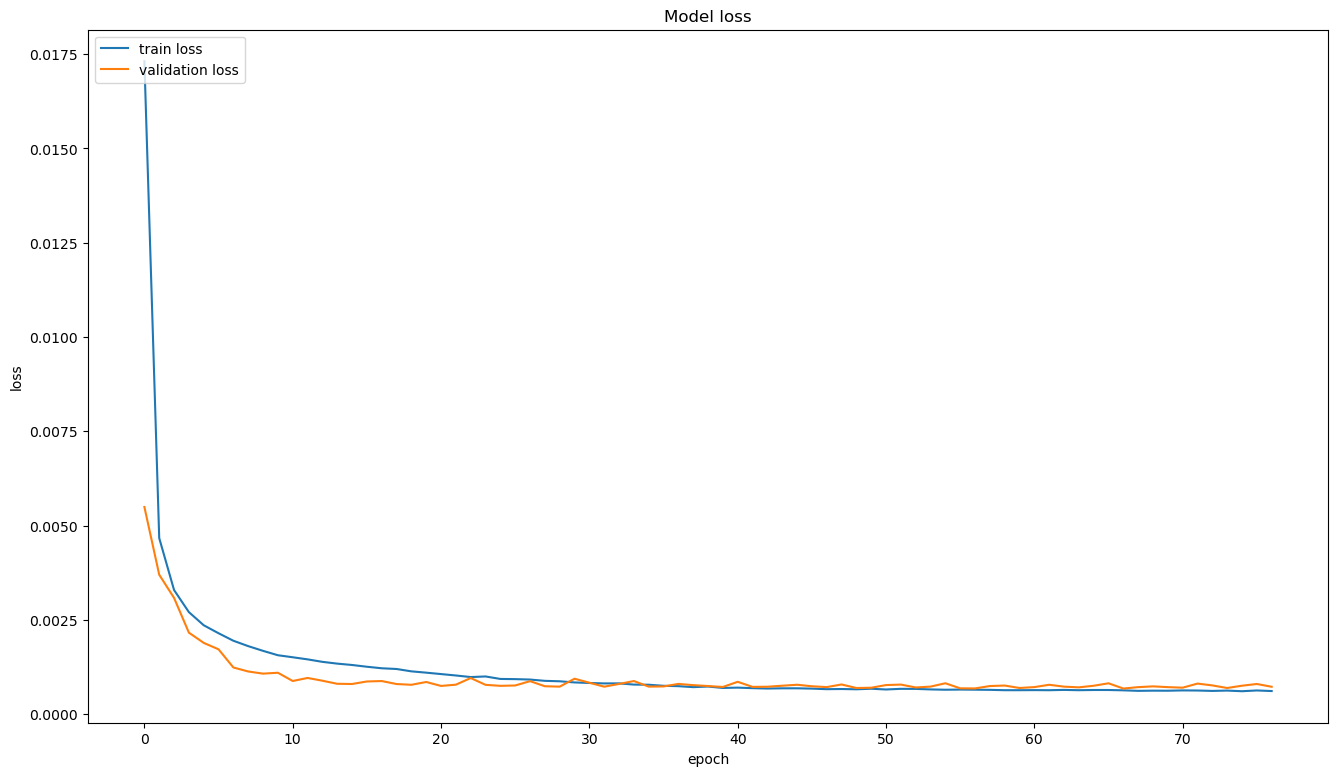

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [69]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = FORECAST_LENGTH
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
for i in range(1, window_len+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    #print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    #print(val_rescaled)

In [70]:
result_inv_trans = scaler_x.inverse_transform(result)

In [71]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 7.183839783084053
MAE is : 2.425351327518622
RMSE is : 2.6802686027866782
MAPE is : 76.32205340569729
R2 is : -5.712945316221441



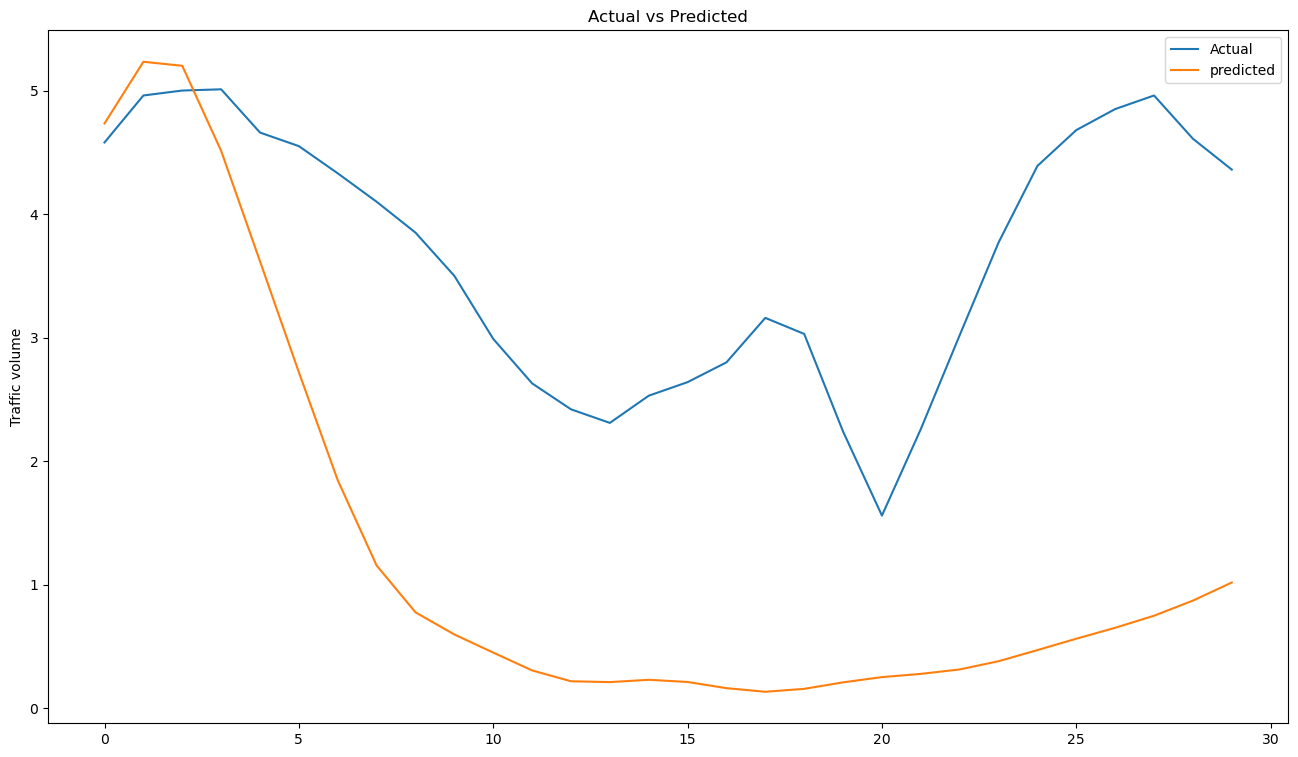

In [72]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## GRU Univariate Horizon

In [73]:
univar_hist_window = WINDOW
horizon = FORECAST_LENGTH
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [74]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [75]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')

In [76]:
model_path = f'MODEL_GRU_Univarient_1_{FEATURE}.h5'

In [77]:
EVALUATION_INTERVAL = 100
history = GRU_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 22s 194ms/step - loss: 0.0567 - val_loss: 0.0241
Epoch 2/100
100/100 [==============================] - 19s 187ms/step - loss: 0.0283 - val_loss: 0.0165
Epoch 3/100
100/100 [==============================] - 19s 190ms/step - loss: 0.0205 - val_loss: 0.0169
Epoch 4/100
100/100 [==============================] - 20s 199ms/step - loss: 0.0186 - val_loss: 0.0158
Epoch 5/100
100/100 [==============================] - 18s 180ms/step - loss: 0.0176 - val_loss: 0.0157
Epoch 6/100
100/100 [==============================] - 17s 167ms/step - loss: 0.0167 - val_loss: 0.0165
Epoch 7/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0158 - val_loss: 0.0149
Epoch 8/100
100/100 [==============================] - 15s 148ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 9/100
100/100 [==============================] - 16s 165ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 10/100
100/100 [==============================] - 18s 178m

In [78]:
Trained_model = tf.keras.models.load_model(model_path)

In [79]:
Trained_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 48, 100)           30900     
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1530      
Total params: 55,230
Trainable params: 55,230
Non-trainable params: 0
_________________________________________________________________


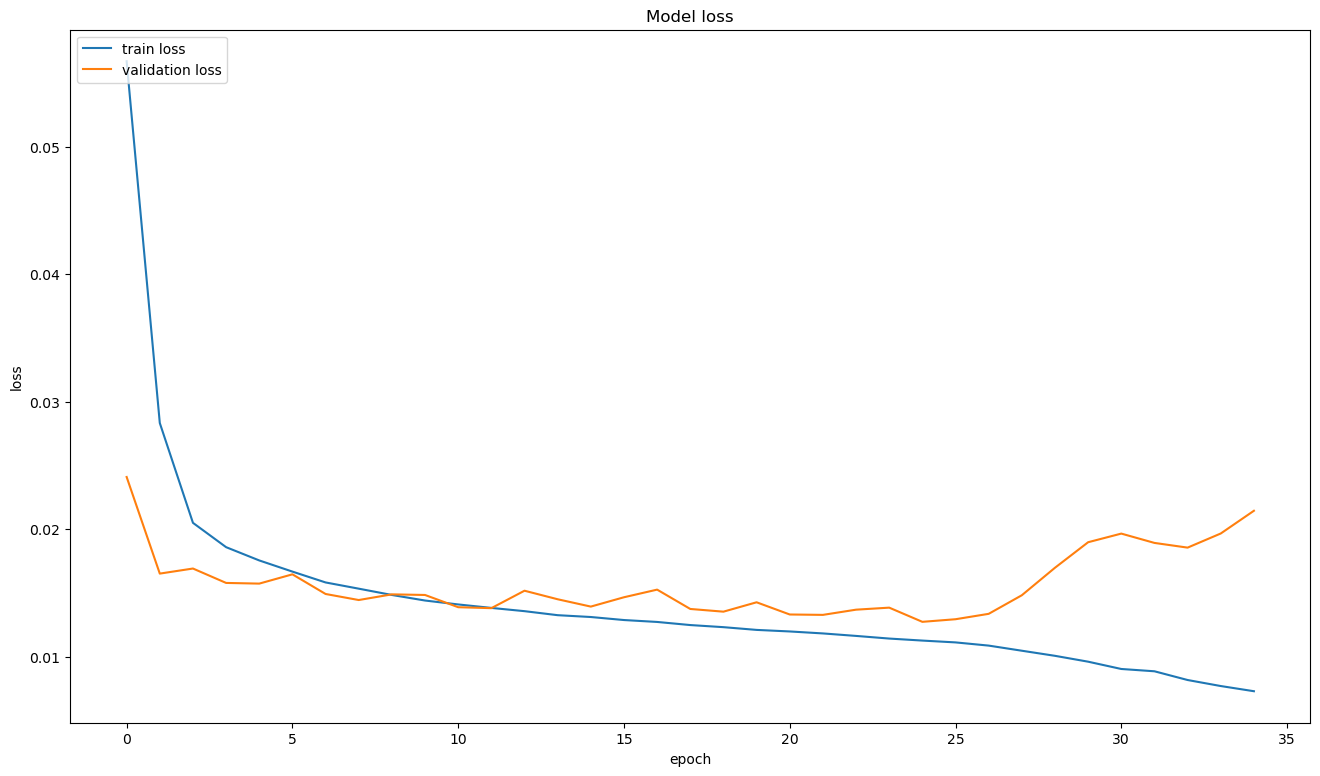

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [81]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [82]:
Predicted_results = Trained_model.predict(val_rescaled)
#Predicted_results

In [83]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)
#Predicted_inver_res

In [84]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 0.40059100176124146
MAE is : 0.48234632841746006
RMSE is : 0.6329225874949017
MAPE is : 17.126408617640127
R2 is : 0.6256673909507597



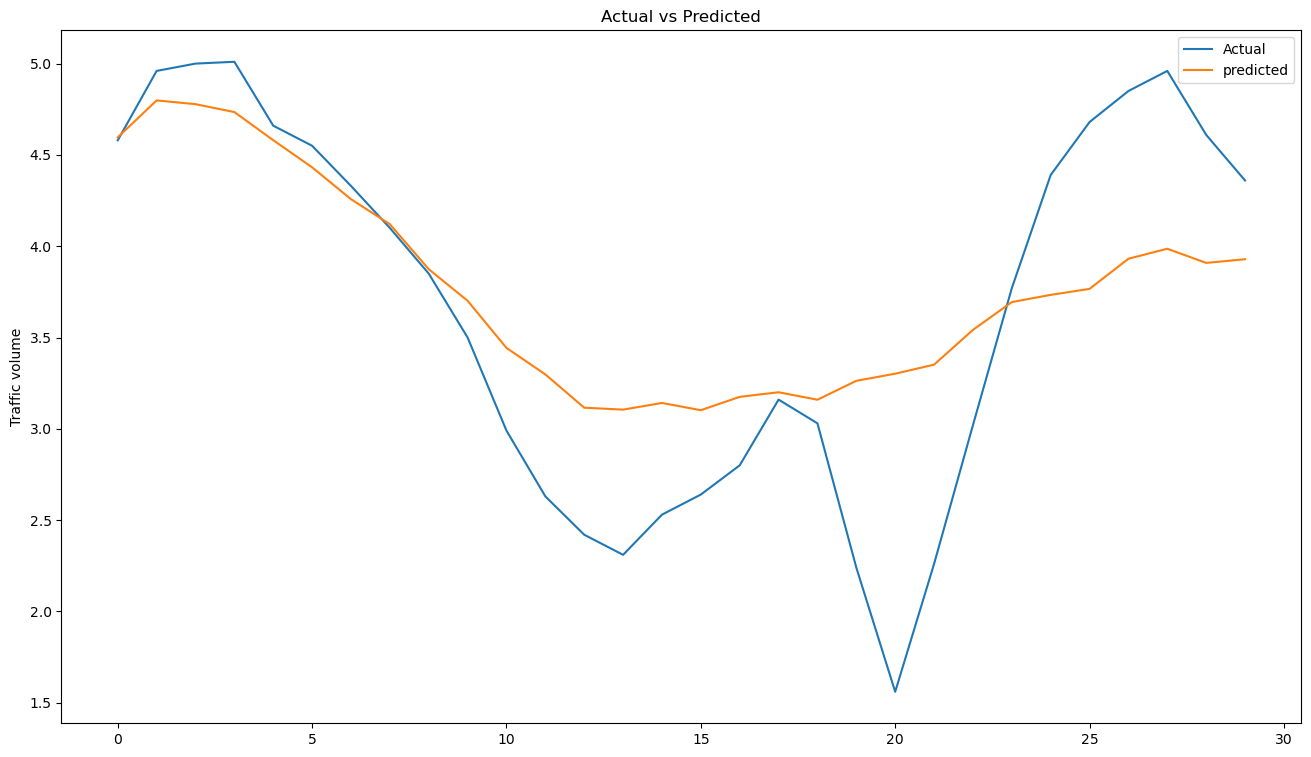

In [85]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Auto-encoder LSTM Univariate Single-Step

In [86]:
univar_hist_window = WINDOW
horizon = 1
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [87]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [88]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]),
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [89]:
model_path = f'MODEL_LSTM_encoder_decoder_Univarient_2_{FEATURE}.h5'

In [90]:
EVALUATION_INTERVAL = 100
history = ED_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate, 
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 37s 290ms/step - loss: 0.0482 - val_loss: 0.0351
Epoch 2/100
100/100 [==============================] - 26s 257ms/step - loss: 0.0299 - val_loss: 0.0351
Epoch 3/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0205 - val_loss: 0.0235
Epoch 4/100
100/100 [==============================] - 29s 291ms/step - loss: 0.0107 - val_loss: 0.0094
Epoch 5/100
100/100 [==============================] - 26s 265ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 6/100
100/100 [==============================] - 28s 284ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 7/100
100/100 [==============================] - 28s 279ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/100
100/100 [==============================] - 37s 375ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/100
100/100 [==============================] - 34s 341ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 10/100
100/100 [==============================] - 32s 320m

In [91]:
Trained_model = tf.keras.models.load_model(model_path)

In [92]:
Trained_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 48, 50)            30200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 15)                3960      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 15)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 100)            46400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 50)             30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)             

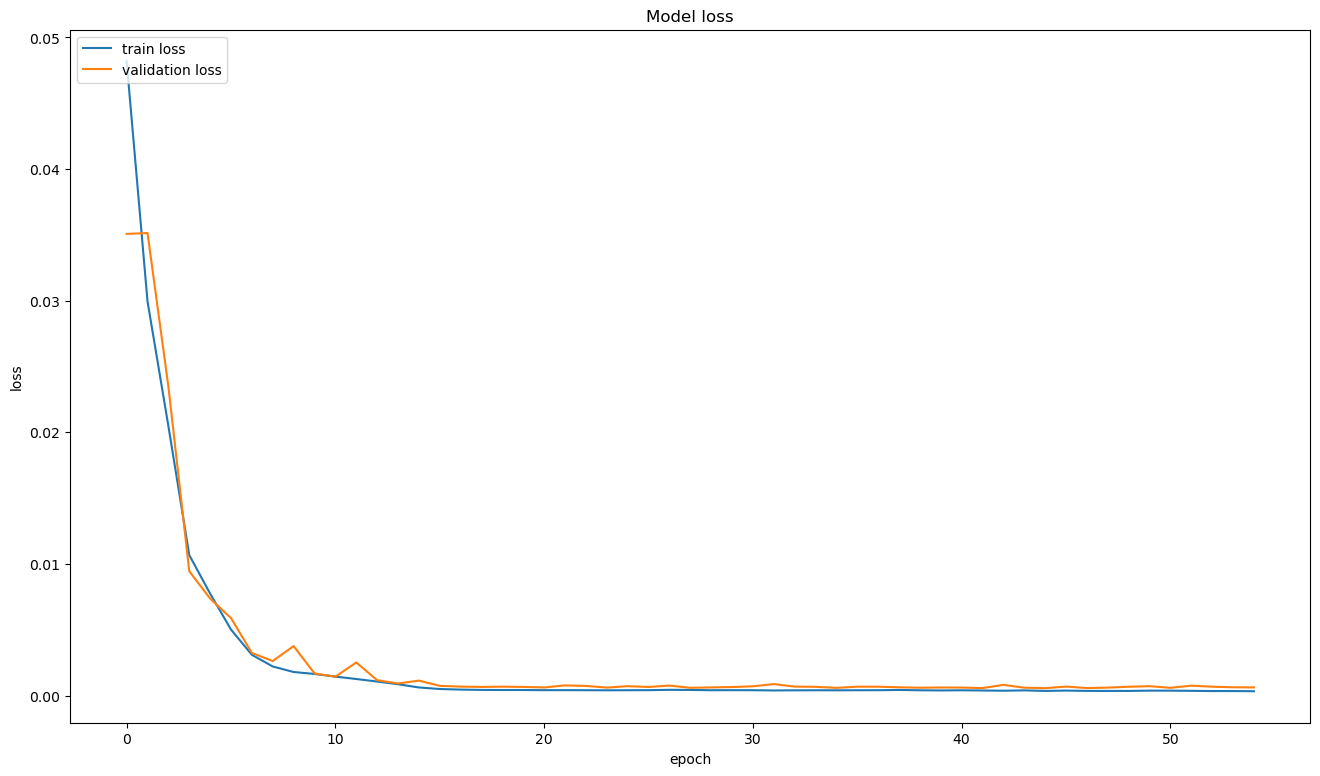

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [94]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = FORECAST_LENGTH
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
for i in range(1, window_len+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    #print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    #print(val_rescaled)

In [95]:
result_inv_trans = scaler_x.inverse_transform(np.array(result).reshape(-1,1))

In [96]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 0.618332671140427
MAE is : 0.6806147259076435
RMSE is : 0.7863413197463471
MAPE is : 34.72629120702661
R2 is : 0.42219849914068486



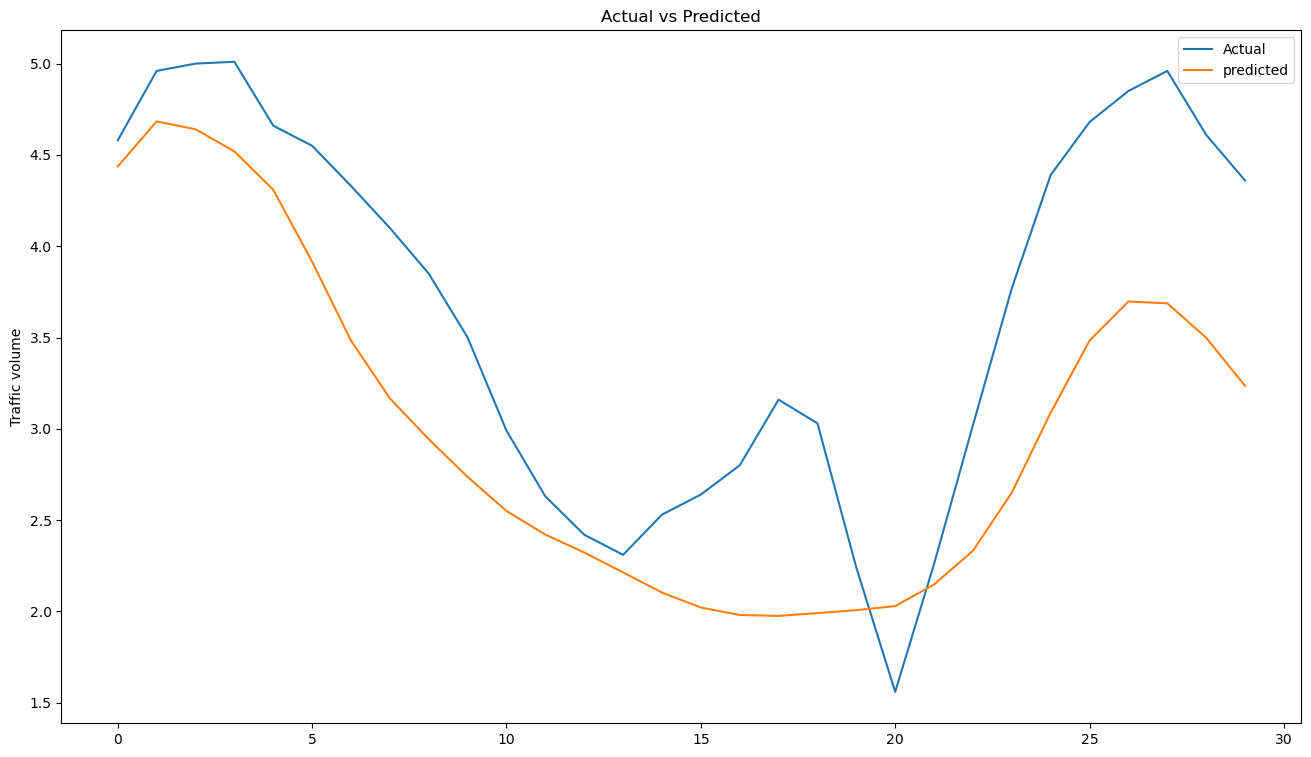

In [97]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Auto-encoder LSTM Univariate Horizon

In [98]:
univar_hist_window = WINDOW
horizon = FORECAST_LENGTH
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [99]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [100]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]),
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [101]:
model_path = f'MODEL_LSTM_encoder_decoder_Univarient_1_{FEATURE}.h5'

In [102]:
EVALUATION_INTERVAL = 100
history = ED_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 44s 390ms/step - loss: 0.0446 - val_loss: 0.0290
Epoch 2/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0323 - val_loss: 0.0323
Epoch 3/100
100/100 [==============================] - 35s 354ms/step - loss: 0.0307 - val_loss: 0.0321
Epoch 4/100
100/100 [==============================] - 37s 371ms/step - loss: 0.0302 - val_loss: 0.0281
Epoch 5/100
100/100 [==============================] - 37s 371ms/step - loss: 0.0264 - val_loss: 0.0193
Epoch 6/100
100/100 [==============================] - 38s 377ms/step - loss: 0.0148 - val_loss: 0.0211
Epoch 7/100
100/100 [==============================] - 36s 361ms/step - loss: 0.0140 - val_loss: 0.0170
Epoch 8/100
100/100 [==============================] - 36s 356ms/step - loss: 0.0138 - val_loss: 0.0159
Epoch 9/100
100/100 [==============================] - 36s 363ms/step - loss: 0.0131 - val_loss: 0.0173
Epoch 10/100
100/100 [==============================] - 36s 357m

In [103]:
Trained_model = tf.keras.models.load_model(model_path)

In [104]:
Trained_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 48, 100)           40800     
_________________________________________________________________
lstm_14 (LSTM)               (None, 48, 50)            30200     
_________________________________________________________________
lstm_15 (LSTM)               (None, 15)                3960      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 15)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 100)           46400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 50)            30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)            

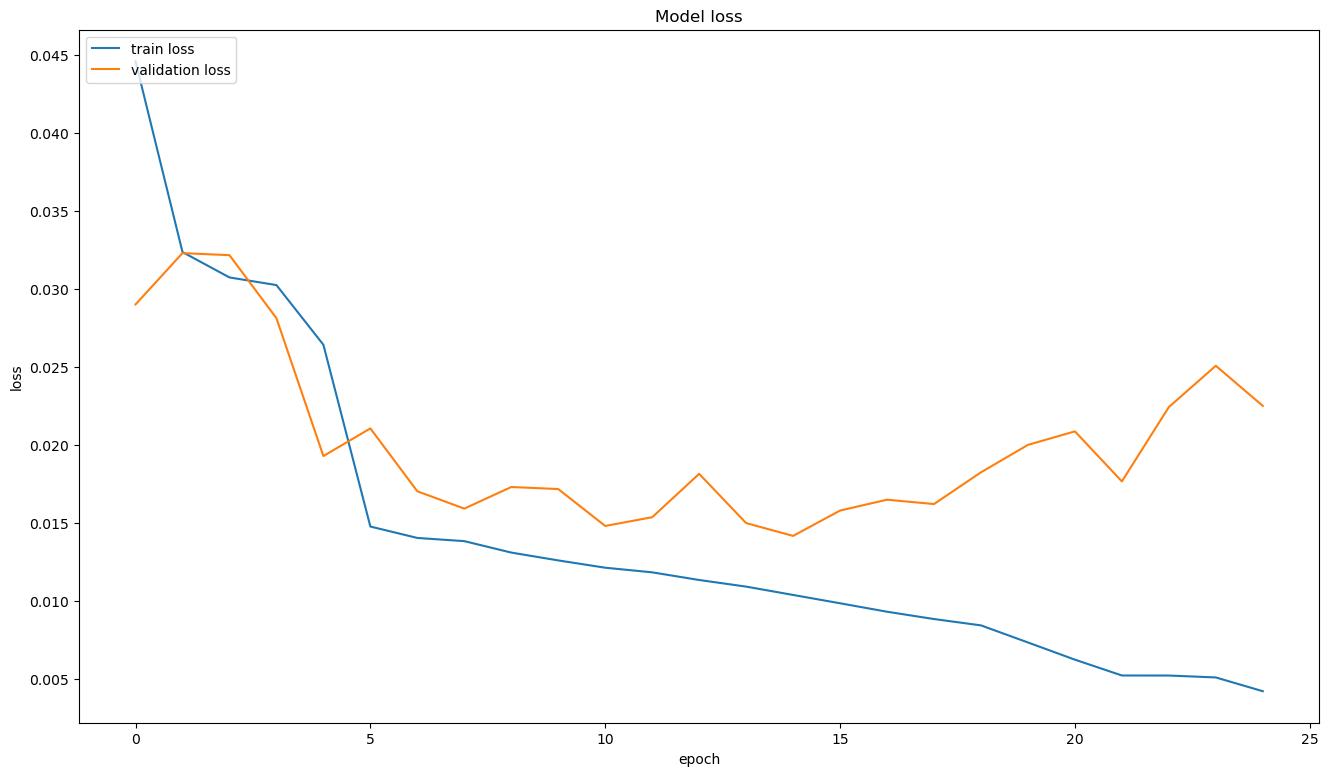

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [106]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
Predicted_results = Trained_model.predict(val_rescaled)
#Predicted_results

In [107]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results[0])
#Predicted_inver_res

In [108]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res)

Evaluation metric results:-
MSE is : 0.8803301042982242
MAE is : 0.8134101076126098
RMSE is : 0.9382590816497457
MAPE is : 31.106972763186665
R2 is : 0.1773747704823564



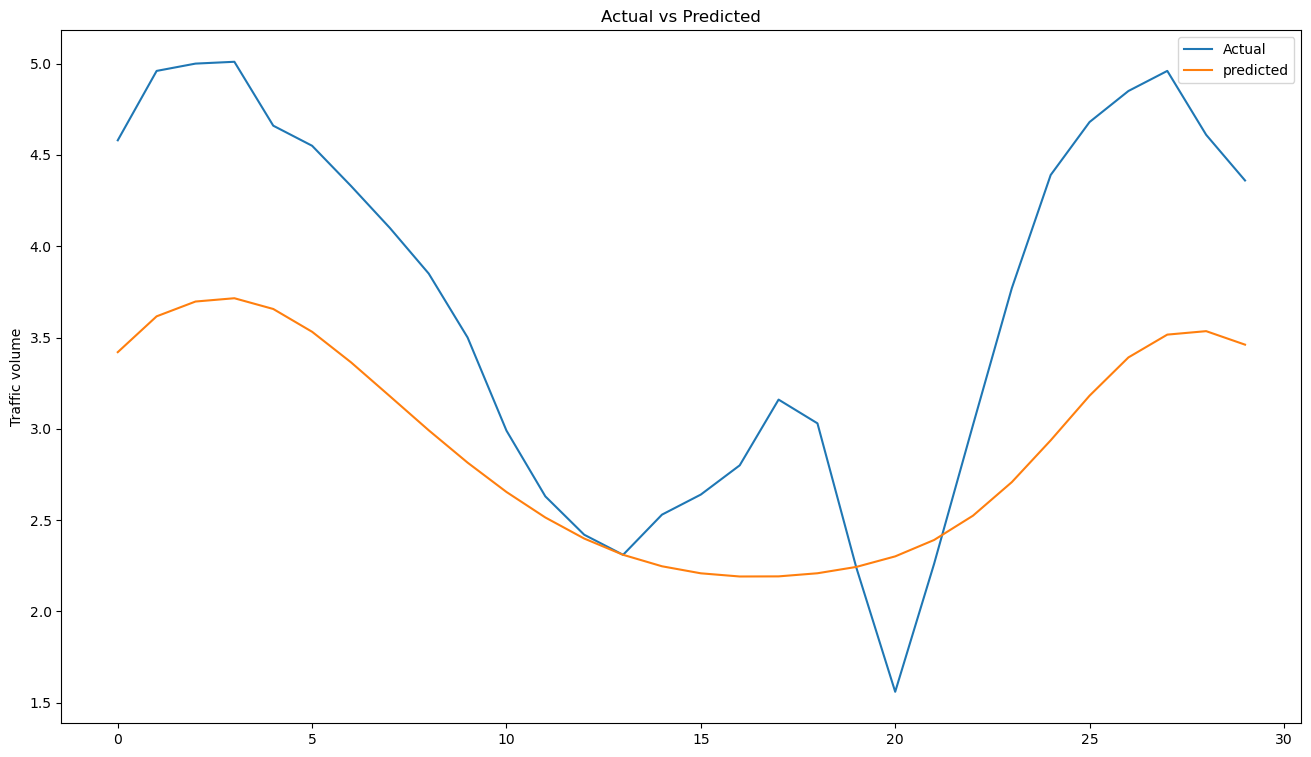

In [109]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## CNN Univariate Single-Step

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

In [111]:
univar_hist_window = WINDOW
horizon = 1
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [112]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [113]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [114]:
model_path = f'MODEL_CNN_Univarient_2_{FEATURE}.h5'

In [115]:
EVALUATION_INTERVAL = 100
history = model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate, 
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0237 - val_loss: 0.0065
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.0029
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 9/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 10/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0035 - val_

In [116]:
Trained_model = tf.keras.models.load_model(model_path)

In [117]:
Trained_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                44190     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

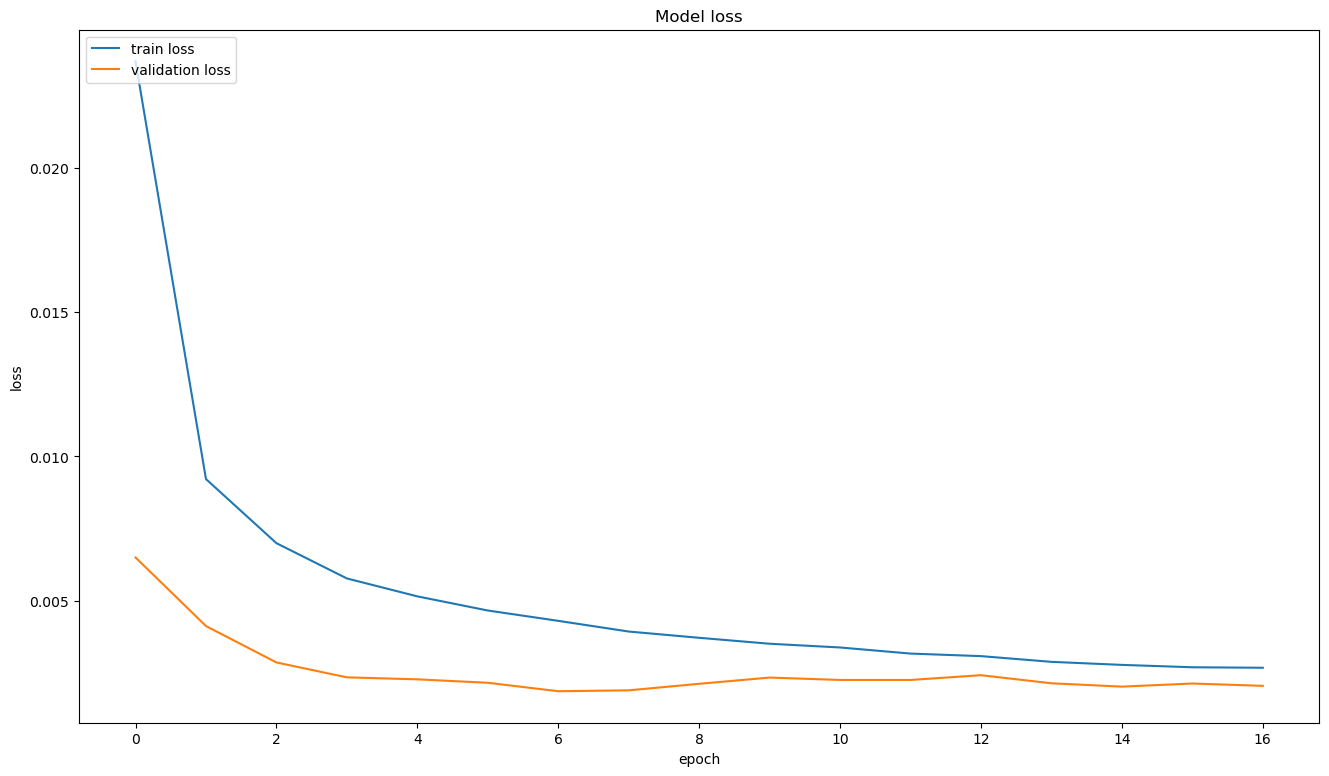

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [119]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = FORECAST_LENGTH
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
for i in range(1, window_len+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    #print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    #print(val_rescaled)

In [120]:
result_inv_trans = scaler_x.inverse_transform(result)

In [121]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 0.5207158793219289
MAE is : 0.5851303347051143
RMSE is : 0.7216064573726657
MAPE is : 33.52220357773815
R2 is : 0.5134165949236101



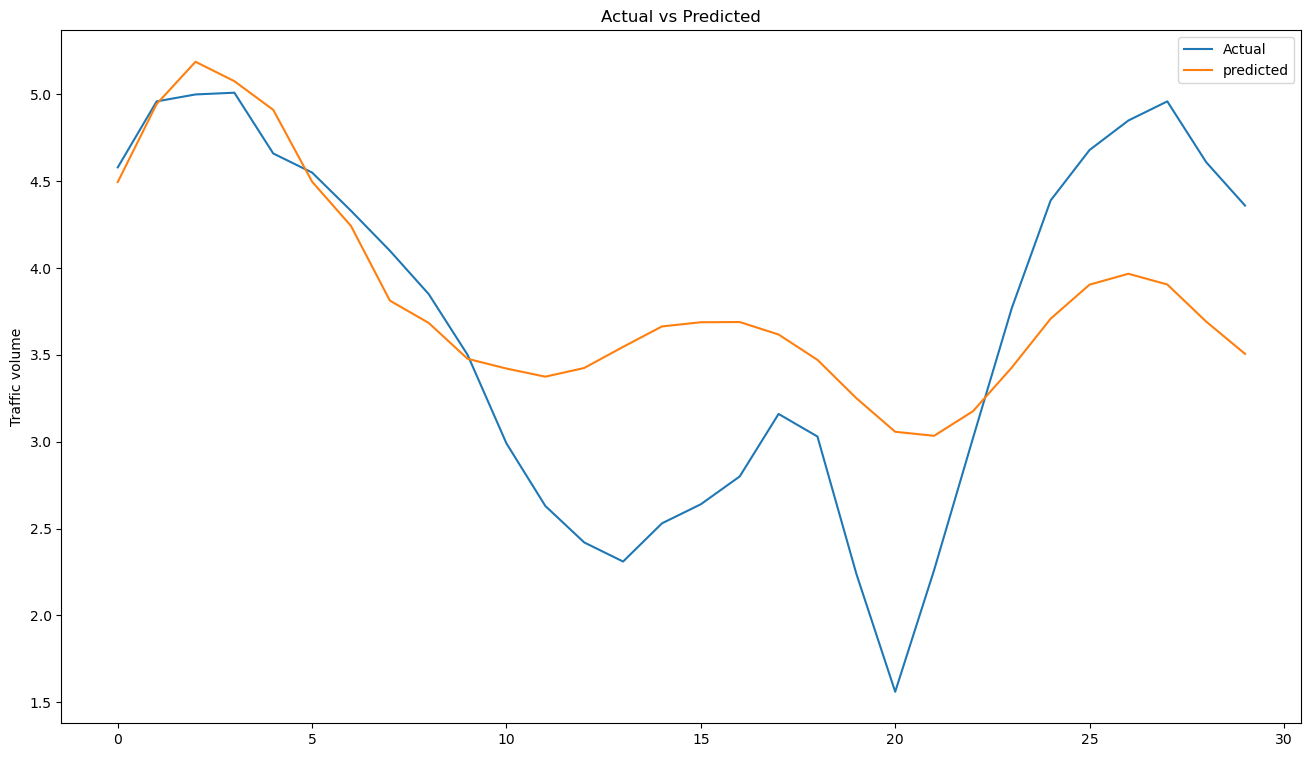

In [122]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## CNN Univariate Horizon

In [123]:
univar_hist_window = WINDOW
horizon = FORECAST_LENGTH
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [124]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [125]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

In [126]:
model_path = f'MODEL_CNN_Univarient_1_{FEATURE}.h5'

In [127]:
EVALUATION_INTERVAL = 100
history = model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,     
    validation_steps=50,
    verbose =1,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 2s 12ms/step - loss: 0.0938 - val_loss: 0.0203
Epoch 2/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0344 - val_loss: 0.0192
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0271 - val_loss: 0.0194
Epoch 4/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0240 - val_loss: 0.0169
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0224 - val_loss: 0.0175
Epoch 6/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0200 - val_loss: 0.0176
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0193 - val_loss: 0.0165
Epoch 9/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0186 - val_loss: 0.0174
Epoch 10/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0179

In [128]:
Trained_model = tf.keras.models.load_model(model_path)

In [129]:
Trained_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1472)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                44190     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)               

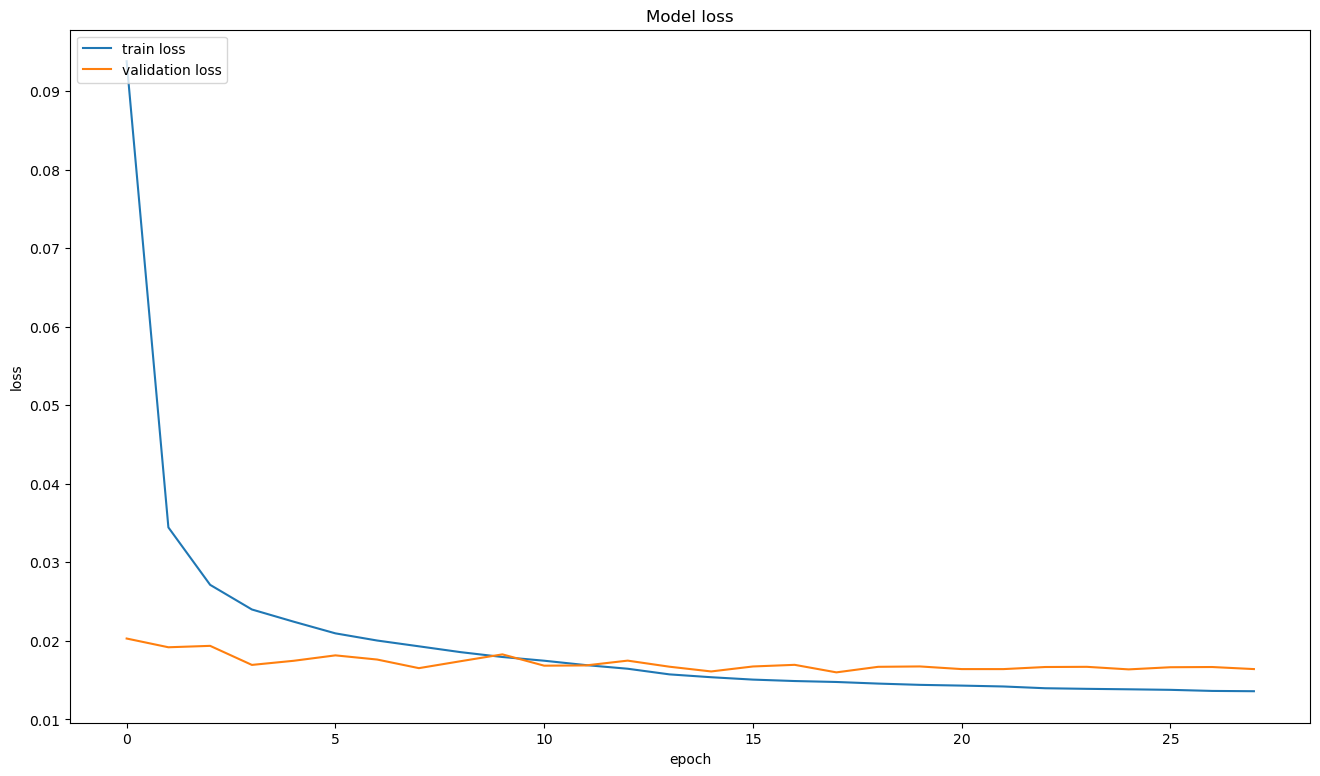

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [131]:
uni = df[FEATURE]
validatehori = uni.tail(WINDOW)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
Predicted_results = Trained_model.predict(val_rescaled)
#Predicted_results

In [132]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)
#Predicted_inver_res

In [133]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 0.3577568884527583
MAE is : 0.528208066622416
RMSE is : 0.598127819494093
MAPE is : 16.985942561389976
R2 is : 0.6656937652841302



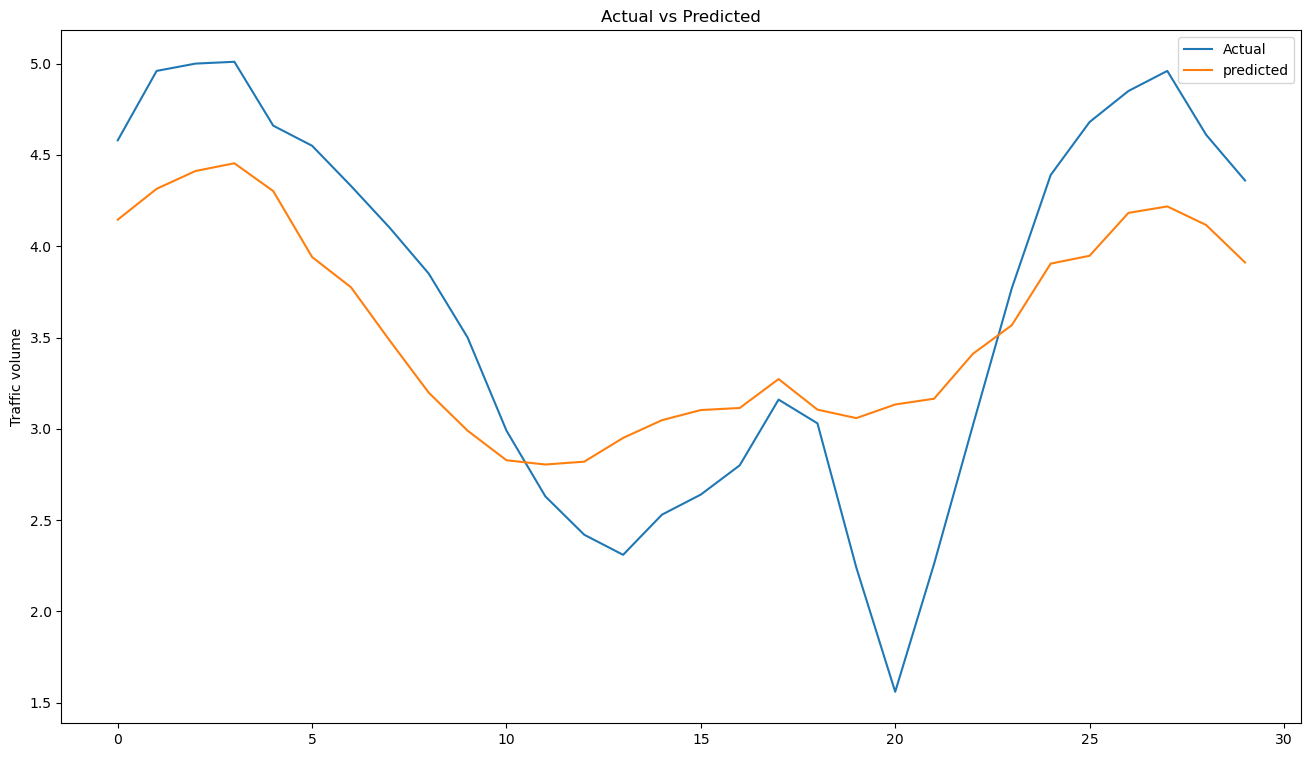

In [134]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()